In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

## Importing Data

In [28]:
df = pd.read_csv("data.csv")
df.head()

gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

In [4]:
df["Total Score"] = df["math_score"]+df["reading_score"]+df["writing_score"]
df["Average_Score"] = df["Total Score"]/3
df.head()

gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  \
0                    none          72             72             74   
1               completed          69             90             88   
2                    none          90             95             93   
3                    none          47             57             44   
4                    none          76             78             75   

   Total Score  Average_Score  
0          218      72.666667  
1          247      82.333333  
2          278      92.666667  
3          148      49.333333  
4          229      76.333333

In [5]:
df.drop(['Average_Score'],axis=1,inplace=True)

In [29]:
df.head()

gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

In [30]:
X = df.drop(['math_score'],axis=1)
X

gender race_ethnicity parental_level_of_education         lunch  \
0    female        group B           bachelor's degree      standard   
1    female        group C                some college      standard   
2    female        group B             master's degree      standard   
3      male        group A          associate's degree  free/reduced   
4      male        group C                some college      standard   
..      ...            ...                         ...           ...   
995  female        group E             master's degree      standard   
996    male        group C                 high school  free/reduced   
997  female        group C                 high school  free/reduced   
998  female        group D                some college      standard   
999  female        group D                some college  free/reduced   

    test_preparation_course  reading_score  writing_score  
0                      none             72             74  
1                 completed             90             88  
2                      none             95             93  
3                      none             57             44  
4                      none             78             75  
..                      ...            ...            ...  
995               completed             99             95  
996                    none             55             55  
997               completed             71             65  
998               completed             78             77  
999                    none             86             86  

[1000 rows x 7 columns]

In [31]:
y = df['math_score']
print(y)

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64


In [32]:
num_features = X.select_dtypes(exclude="object").columns
categorial_features = X.select_dtypes(include="object").columns

In [33]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

num_transformer = StandardScaler()
categorial_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',categorial_transformer,categorial_features),
        ('StandardScaler',num_transformer,num_features)
    ]
)


In [34]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

print("Numerical features are : ", numerical_features)
print("Categorical features are : ",categorical_features)

Numerical features are :  ['math_score', 'reading_score', 'writing_score']
Categorical features are :  ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


In [35]:
X = preprocessor.fit_transform(X)
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]], shape=(1000, 19))

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape

((800, 19), (200, 19))

## Evaluation Function for model metrics

In [43]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = root_mean_squared_error(true,predicted)
    r2_square = r2_score(true,predicted)

    return mae,mse,rmse,r2_square

In [44]:
models = {
    'Linear Regression' : LinearRegression(),
    "Ridge" : Ridge(),
    "Lasso" : Lasso(),
    "K-Neighbours Regressor" : KNeighborsRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest" : RandomForestRegressor(),
    "CatBoost" : CatBoostRegressor(),
    "AdaBoost" : AdaBoostRegressor()
}

model_list = []
r2_list = []

In [45]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae,model_train_mse,model_train_rmse,model_train_r2 = evaluate_model(y_train,y_train_pred)
    model_test_mae,model_test_mse,model_test_rmse,model_test_r2 = evaluate_model(y_test,y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model performance for training set")
    print("--Mean Absolute Error : {:0.4}".format(model_train_mae))
    print("--Mean Square Error : {:0.4}".format(model_train_mse))
    print("--Root Mean Square Error : {:0.4}".format(model_train_rmse))
    print("--R2 Score : {:0.4}".format(model_train_r2))

    print("-----------------------")

    
    print("Model performance for test set")
    print("--Mean Absolute Error : {:0.4}".format(model_test_mae))
    print("--Mean Square Error : {:0.4}".format(model_test_mse))
    print("--Root Mean Square Error : {:0.4}".format(model_test_rmse))
    print("--R2 Score : {:0.4}".format(model_test_r2))
    r2_list.append(model_test_r2)

    



Linear Regression
Model performance for training set
--Mean Absolute Error : 4.267
--Mean Square Error : 28.33
--Root Mean Square Error : 5.323
--R2 Score : 0.8743
-----------------------
Model performance for test set
--Mean Absolute Error : 4.215
--Mean Square Error : 29.1
--Root Mean Square Error : 5.394
--R2 Score : 0.8804
Ridge
Model performance for training set
--Mean Absolute Error : 4.265
--Mean Square Error : 28.34
--Root Mean Square Error : 5.323
--R2 Score : 0.8743
-----------------------
Model performance for test set
--Mean Absolute Error : 4.211
--Mean Square Error : 29.06
--Root Mean Square Error : 5.39
--R2 Score : 0.8806
Lasso
Model performance for training set
--Mean Absolute Error : 5.206
--Mean Square Error : 43.48
--Root Mean Square Error : 6.594
--R2 Score : 0.8071
-----------------------
Model performance for test set
--Mean Absolute Error : 5.158
--Mean Square Error : 42.51
--Root Mean Square Error : 6.52
--R2 Score : 0.8253
K-Neighbours Regressor
Model performa

In [46]:
pd.DataFrame(list(zip(model_list,r2_list)),columns=['Model Name','R2 Score']).sort_values(by=['R2 Score'],ascending=False)

Model Name  R2 Score
1                   Ridge  0.880593
0       Linear Regression  0.880433
6                CatBoost  0.851632
5           Random Forest  0.850033
7                AdaBoost  0.849918
2                   Lasso  0.825320
3  K-Neighbours Regressor  0.783813
4           Decision Tree  0.713547

In [47]:
lin_model = LinearRegression(fit_intercept = True)
lin_model = lin_model.fit(X_train,y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test,y_pred)*100
print("Accuracy of the model : %.2f" %score)


Accuracy of the model : 88.04


Text(0, 0.5, 'Predicted')

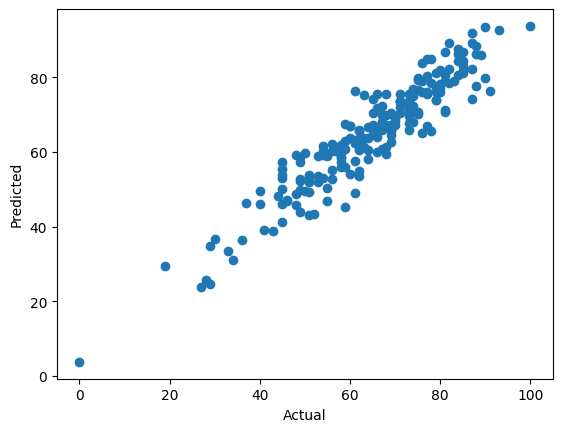

In [48]:
plt.scatter(y_test,y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

<Axes: xlabel='math_score'>

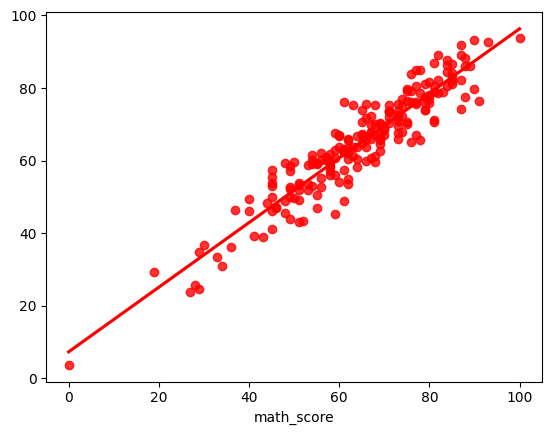

In [49]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='Red')


In [50]:
pred_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value' : y_pred,'Difference' : y_test-y_pred})
pred_df

Actual Value  Predicted Value  Difference
521            91        76.387970   14.612030
737            53        58.885970   -5.885970
740            80        76.990265    3.009735
660            74        76.851804   -2.851804
411            84        87.627378   -3.627378
..            ...              ...         ...
408            52        43.409149    8.590851
332            62        62.152214   -0.152214
208            74        67.888395    6.111605
613            65        67.022287   -2.022287
78             61        62.345132   -1.345132

[200 rows x 3 columns]